In [130]:
import numpy as np
np.float = float    
import pandas as pd
import matplotlib.pyplot as plt
import lucem_illud
import seaborn as sns
from tqdm.auto import tqdm
import ast

import sklearn.feature_extraction.text
import gensim
from gensim.models import LdaModel
import openai
from openai._client import OpenAI
import re


In [2]:
df = pd.read_csv('/Users/itsyuzhou/Spring2024/thesis_clean/Data/preprocessed_comments.csv', lineterminator='\n')
china_df = pd.read_csv('/Users/itsyuzhou/Spring2024/thesis_clean/Data/scored_china.csv', lineterminator='\n')

In [3]:
def string_to_list(comment_str):
    try:
        return ast.literal_eval(comment_str)
    except:
        return []

df['reduced_comment'] = df['reduced_comment'].apply(string_to_list)
china_df['reduced_comment'] = china_df['reduced_comment'].apply(string_to_list)

# 1. Hate Analysis

In [4]:
comment_df = china_df.copy(deep=True)
start_date = pd.Timestamp('2019-12-20')
end_date = pd.Timestamp('2021-12-31')
comment_df['Comment PublishedAt'] = pd.to_datetime(comment_df['Comment PublishedAt'])
comment_df = comment_df[(comment_df['Comment PublishedAt'] >= start_date) & (comment_df['Comment PublishedAt'] <= end_date)]
comment_df.set_index('Comment PublishedAt', inplace=True)

## 1.1 Overall Hate

In [57]:
hate_amount_w = comment_df[comment_df['Hate Speech Score'] > 0.34].resample('W').size()
hate_intensity_w = comment_df['Hate Speech Score'].resample('W').mean()

hate_amount_w.fillna(0, inplace=True)
hate_intensity_w.fillna(0, inplace=True)

In [6]:
min_val = hate_amount_w.min()
max_val = hate_amount_w.max()
scaled_hate_amount_w = (hate_amount_w - min_val) / (max_val - min_val)

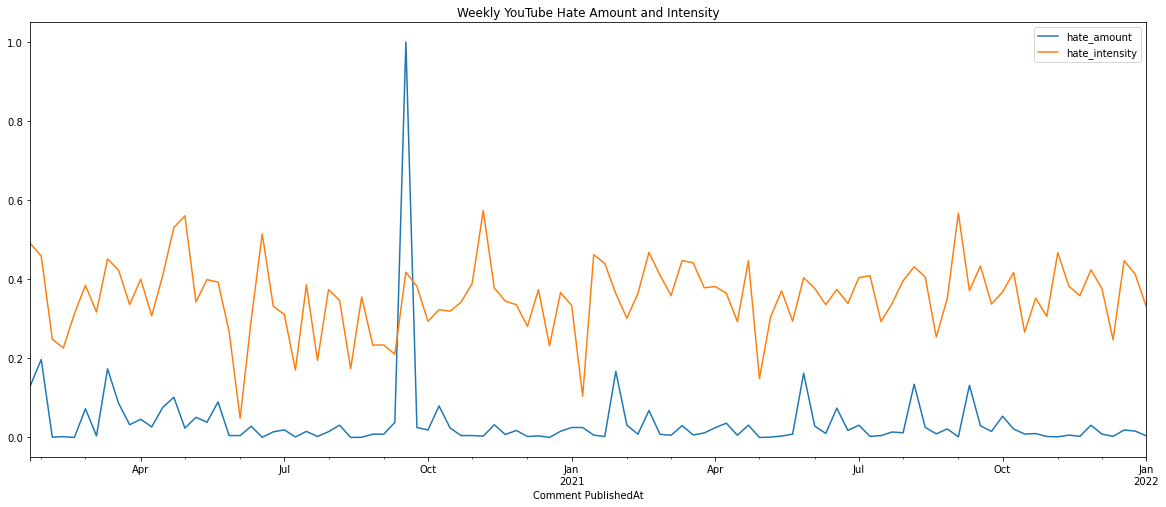

In [7]:
weekly_hate_df = pd.DataFrame({
    'hate_amount': scaled_hate_amount_w.values,
    'hate_intensity': hate_intensity_w.values
    }, index=scaled_hate_amount_w.index)

plot = weekly_hate_df.plot(figsize=(20, 8), title="Weekly YouTube Hate Amount and")

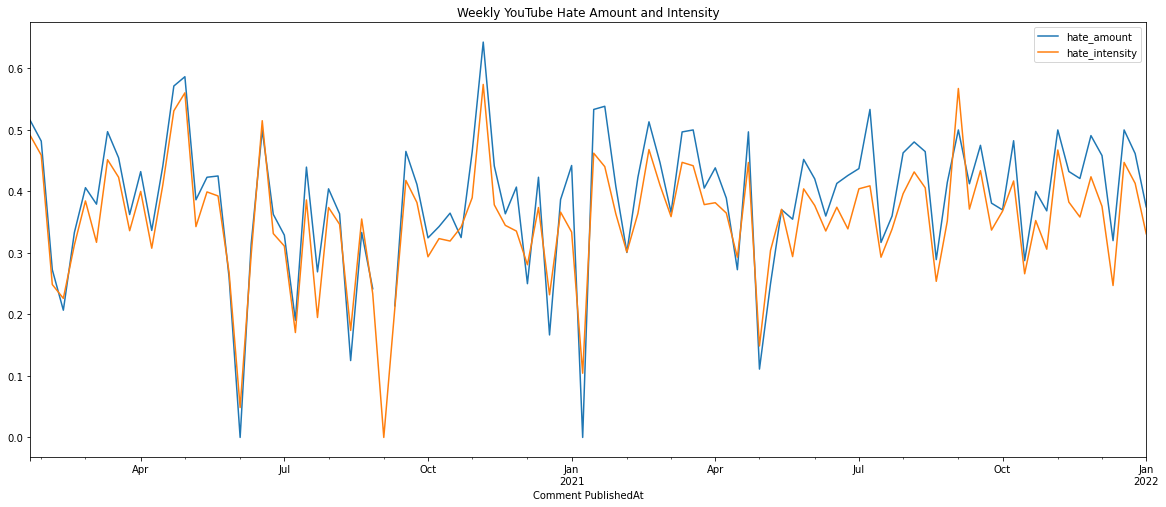

In [61]:
total_comments_w = comment_df.resample('W').size()
hate_amount_prop = hate_amount_w/total_comments_w

weekly_hate_df = pd.DataFrame({
    'hate_amount': hate_amount_prop.values,
    'hate_intensity': hate_intensity_w.values
    }, index=hate_intensity_w.index)

plot = weekly_hate_df.plot(figsize=(20, 8), title="Weekly YouTube Hate Amount and Intensity")

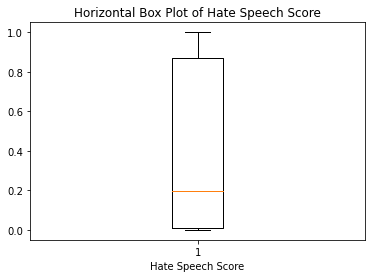

In [238]:
plt.boxplot(china_df['Hate Speech Score'], vert=True)
plt.title('Horizontal Box Plot of Hate Speech Score')
plt.xlabel('Hate Speech Score')

plt.show()

<AxesSubplot:title={'center':'Hate Score Distribution'}, ylabel='Frequency'>

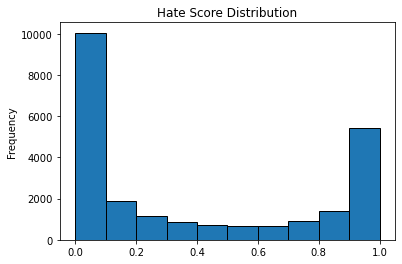

In [75]:
china_df['Hate Speech Score'].plot(kind='hist', edgecolor='black', title='Hate Score Distribution')

In [65]:
weekly_hate_df.to_csv('weekly_hate_df.csv')

## 1.2 By Channel

In [67]:
filtered_df = comment_df[comment_df['Hate Speech Score'] > 0.34]
hate_counts = filtered_df.groupby([pd.Grouper(freq='W'), 'Channel']).size()
hate_counts_unstacked = hate_counts.unstack(fill_value=0)

abc_hate_amount = hate_counts_unstacked['ABC']
total_abc = comment_df[comment_df['Channel']=='ABC'].resample('W').size()
abc_prop = abc_hate_amount/total_abc

fox_hate_amount = hate_counts_unstacked['FOX']
total_fox = comment_df[comment_df['Channel']=='FOX'].resample('W').size()
fox_prop = fox_hate_amount/total_fox

msnbc_hate_amount = hate_counts_unstacked['MSNBC']
total_msnbc = comment_df[comment_df['Channel']=='MSNBC'].resample('W').size()
msnbc_prop = msnbc_hate_amount/total_msnbc

In [9]:
hate_intensity = comment_df.groupby([pd.Grouper(freq='W'), 'Channel'])['Hate Speech Score'].mean()
hate_intensity_unstacked = hate_intensity.unstack(fill_value=0)

abc_hate_intensity = hate_intensity_unstacked['ABC']
fox_hate_intensity = hate_intensity_unstacked['FOX']
msnbc_hate_intensity = hate_intensity_unstacked['MSNBC']

In [68]:
abc_prop = abc_prop.fillna(0)
fox_prop = fox_prop.fillna(0)
msnbc_prop = msnbc_prop.fillna(0)

abc_hate_intensity = abc_hate_intensity.fillna(method='ffill')
fox_hate_intensity = fox_hate_intensity.fillna(method='ffill')
msnbc_hate_intensity = msnbc_hate_intensity.fillna(method='ffill')

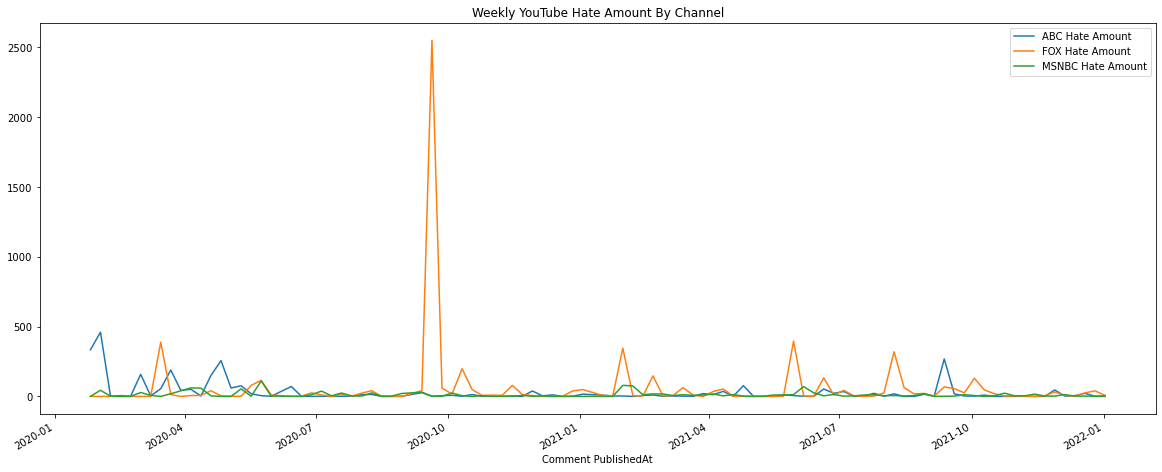

In [70]:
weekly_amount_channel = pd.DataFrame({
    'ABC Hate Amount': abc_hate_amount.values,
    'FOX Hate Amount': fox_hate_amount.values,
    'MSNBC Hate Amount': msnbc_hate_amount.values
    }, index=abc_hate_amount.index)

plot = weekly_amount_channel.plot(figsize=(20, 8), title="Weekly YouTube Hate Amount By Channel")

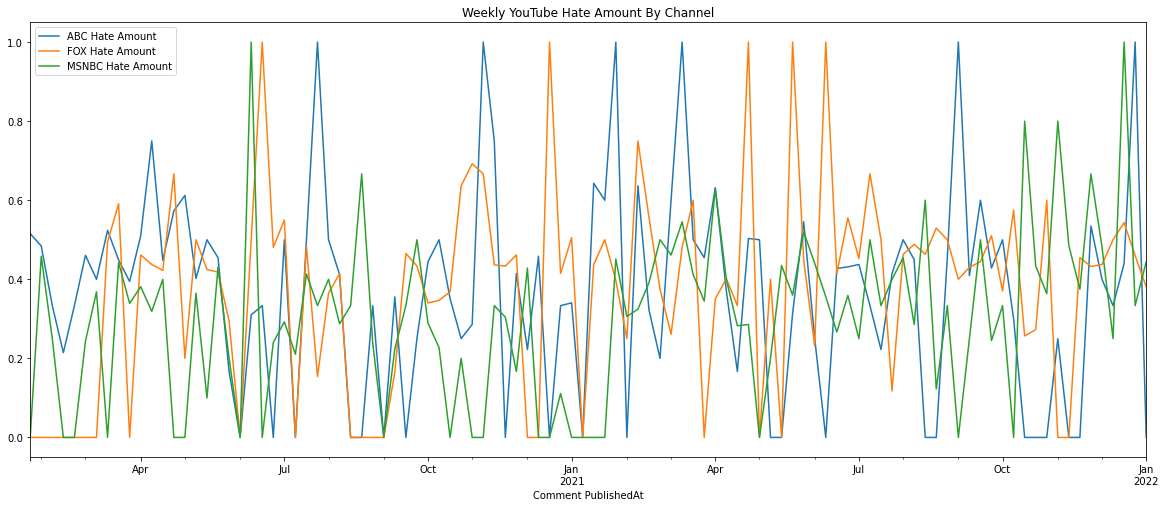

In [69]:
weekly_amount_channel = pd.DataFrame({
    'ABC Hate Amount': abc_prop.values,
    'FOX Hate Amount': fox_prop.values,
    'MSNBC Hate Amount': msnbc_prop.values
    }, index=msnbc_prop.index)

plot = weekly_amount_channel.plot(figsize=(20, 8), title="Weekly YouTube Hate Amount By Channel")

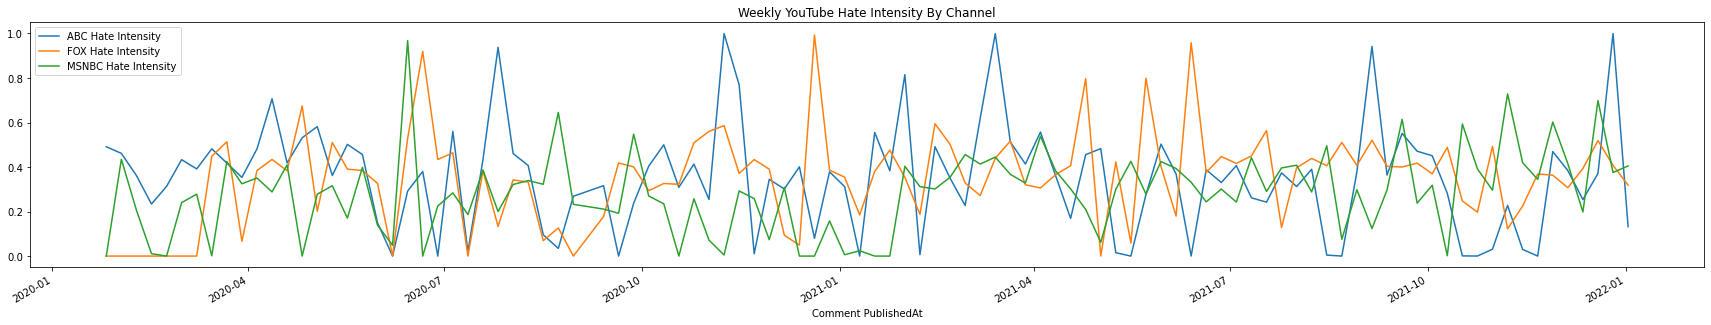

In [12]:
weekly_intensity_channel = pd.DataFrame({
    'ABC Hate Intensity': abc_hate_intensity.values,
    'FOX Hate Intensity': fox_hate_intensity.values,
    'MSNBC Hate Intensity': msnbc_hate_intensity.values
    }, index=abc_hate_intensity.index)

plot = weekly_intensity_channel.plot(figsize=(30, 5), title="Weekly YouTube Hate Intensity By Channel")

In [72]:
china_df.groupby('Channel')['Hate Speech Score'].describe()

,count,mean,std,min,25%,50%,75%,max
Channel,,,,,,,,
ABC,6354.0,0.422470,0.425488,0.000132,0.005817,0.224864,0.940792,0.999807
FOX,13824.0,0.398500,0.402363,0.000131,0.010010,0.212069,0.863458,0.999809
MSNBC,3580.0,0.325341,0.372778,0.000132,0.007897,0.138765,0.690037,0.999800


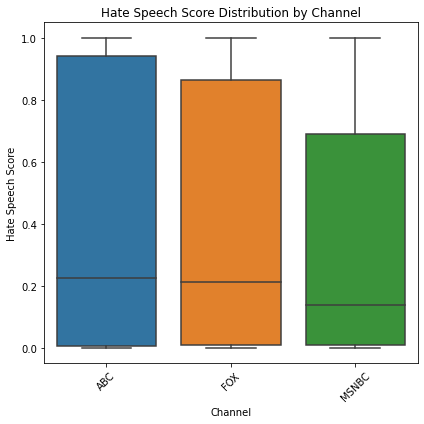

In [73]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Channel', y='Hate Speech Score', data=china_df)

plt.title('Hate Speech Score Distribution by Channel')
plt.xlabel('Channel')
plt.ylabel('Hate Speech Score')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

# 2. Topic Modeling

In [14]:
def comment2document(list_of_lists):
    '''
    Function to concatenate lists of words, i.e., combine all comments from a
    given video to one document
    '''
    concatenated_list = []
    for sublist in list_of_lists:
        concatenated_list.extend(sublist)
    return concatenated_list

In [20]:
def format_topics_documents(ldamodel, corpus):
    topics_data = []
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_data.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break
    topics_df = pd.DataFrame(topics_data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    return topics_df

## 2.1 All Comments

### 2.1.1 All Channels

In [17]:
comments_by_video = df.groupby('Video Title')['reduced_comment'].agg(comment2document).reset_index()
dictionary = gensim.corpora.Dictionary(comments_by_video['reduced_comment'])
corpus = [dictionary.doc2bow(text) for text in comments_by_video['reduced_comment']]

In [18]:
lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=10,
                random_state=42,
                update_every=1,
                chunksize=100,
                passes=15,
                alpha='auto')

In [19]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.032*"people" + 0.024*"vaccinated" + 0.021*"biden" + 0.021*"vaccine" + 0.017*"covid" + 0.011*"like" + 0.011*"joe" + 0.009*"government" + 0.008*"unvaccinated" + 0.008*"want"

Topic: 1
Words: 0.025*"gates" + 0.024*"people" + 0.019*"vaccine" + 0.016*"pandemic" + 0.015*"know" + 0.013*"world" + 0.013*"like" + 0.012*"vaccines" + 0.011*"god" + 0.011*"man"

Topic: 2
Words: 0.030*"people" + 0.023*"virus" + 0.015*"trump" + 0.012*"coronavirus" + 0.010*"like" + 0.009*"world" + 0.009*"china" + 0.009*"cases" + 0.008*"death" + 0.008*"going"

Topic: 3
Words: 0.064*"trump" + 0.027*"president" + 0.019*"people" + 0.016*"biden" + 0.014*"like" + 0.010*"news" + 0.008*"fox" + 0.008*"covid" + 0.007*"said" + 0.007*"know"

Topic: 4
Words: 0.025*"people" + 0.023*"trump" + 0.018*"america" + 0.017*"world" + 0.016*"country" + 0.015*"like" + 0.014*"cases" + 0.010*"usa" + 0.010*"countries" + 0.009*"americans"

Topic: 5
Words: 0.032*"people" + 0.021*"news" + 0.021*"covid" + 0.013*"fox" + 0.013*"like" 

In [21]:
dominant_topics_df = format_topics_documents(ldamodel=lda_model, corpus=corpus)
topic_counts = dominant_topics_df['Dominant_Topic'].value_counts().reset_index(name="Num_Documents")
topic_counts.columns = ['Topic_Num', 'Num_Documents']
topic_counts = topic_counts.merge(dominant_topics_df[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().rename(columns={'Dominant_Topic':'Topic_Num'}), on='Topic_Num', how='left')

print(topic_counts.sort_values(by='Num_Documents', ascending=False))

   Topic_Num  Num_Documents                                     Topic_Keywords
0          2             49  people, virus, trump, coronavirus, like, world...
1          3             43  trump, president, people, biden, like, news, f...
2          6             37  vaccine, people, covid, like, shot, got, getti...
3          5             22  people, news, covid, fox, like, media, know, c...
4          0             22  people, vaccinated, biden, vaccine, covid, lik...
5          7             15  china, virus, world, fauci, chinese, people, l...
6          4              8  people, trump, america, world, country, like, ...
7          1              4  gates, people, vaccine, pandemic, know, world,...
8          8              2  virus, people, like, test, vaccine, flu, know,...
9          9              2  love, rachel, susan, thank, hope, beautiful, p...


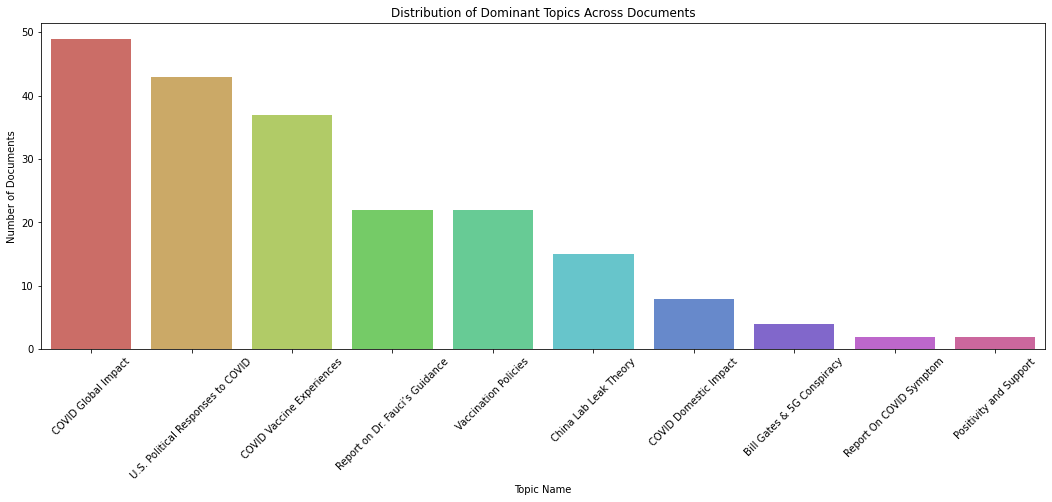

In [23]:
topic_names = {
    0: 'Vaccination Policies',
    1: 'Bill Gates & 5G Conspiracy',
    2: 'COVID Global Impact',
    3: 'U.S. Political Responses to COVID',
    4: 'COVID Domestic Impact',
    5: 'Report on Dr. Fauci’s Guidance',
    6: 'COVID Vaccine Experiences',
    7: 'China Lab Leak Theory',
    8: 'Report On COVID Symptom',
    9: 'Positivity and Support'
}

topic_counts['Topic'] = topic_counts['Topic_Num'].map(topic_names)

plt.figure(figsize=(18, 6))

sns.barplot(x='Topic', y='Num_Documents', data=topic_counts, palette='hls')
plt.xlabel('Topic Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.title('Distribution of Dominant Topics Across Documents')
plt.show()

### 2.1.2 By Channels

In [24]:
abc_df = df[df['Channel'] == 'ABC']
fox_df = df[df['Channel'] == 'FOX']
msnbc_df = df[df['Channel'] == 'MSNBC']

In [25]:
comments_by_video = abc_df.groupby('Video Title')['reduced_comment'].agg(comment2document).reset_index()
dictionary = gensim.corpora.Dictionary(comments_by_video['reduced_comment'])
corpus = [dictionary.doc2bow(text) for text in comments_by_video['reduced_comment']]

lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=5,
                random_state=42,
                update_every=1,
                chunksize=100,
                passes=15,
                alpha='auto')

In [26]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.029*"people" + 0.029*"virus" + 0.025*"china" + 0.015*"like" + 0.012*"world" + 0.010*"coronavirus" + 0.009*"know" + 0.008*"chinese" + 0.007*"going" + 0.007*"infected"

Topic: 1
Words: 0.031*"people" + 0.022*"biden" + 0.021*"vaccine" + 0.019*"vaccinated" + 0.013*"like" + 0.012*"joe" + 0.012*"president" + 0.012*"covid" + 0.009*"trump" + 0.008*"unvaccinated"

Topic: 2
Words: 0.031*"vaccine" + 0.028*"people" + 0.022*"covid" + 0.015*"like" + 0.012*"shot" + 0.010*"got" + 0.010*"know" + 0.009*"getting" + 0.008*"vaccinated" + 0.007*"vaccines"

Topic: 3
Words: 0.026*"people" + 0.019*"trump" + 0.013*"like" + 0.010*"virus" + 0.009*"covid" + 0.008*"news" + 0.008*"going" + 0.007*"know" + 0.007*"god" + 0.007*"time"

Topic: 4
Words: 0.033*"vaccine" + 0.031*"people" + 0.023*"vaccines" + 0.021*"vaccinated" + 0.016*"covid" + 0.013*"variant" + 0.010*"cdc" + 0.009*"know" + 0.008*"like" + 0.008*"virus"



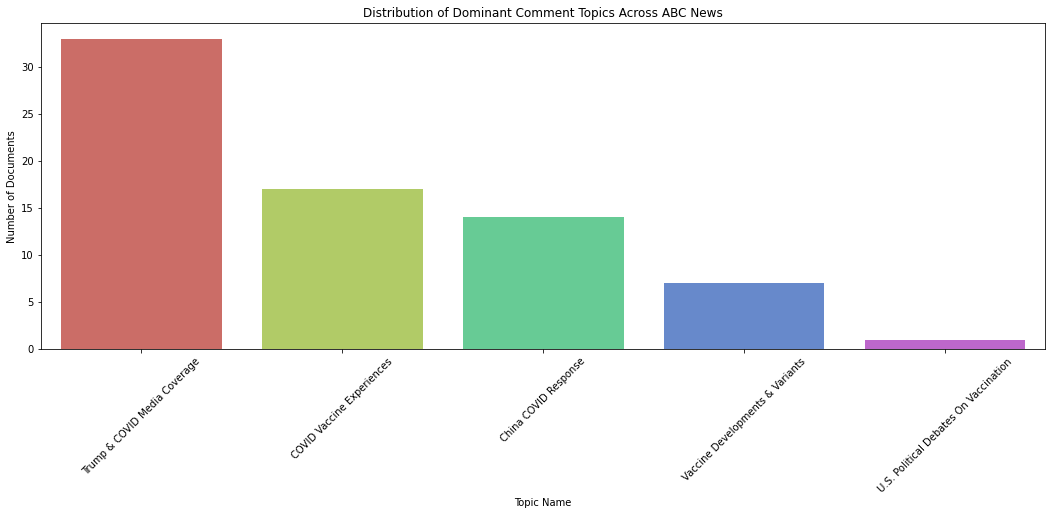

In [28]:
dominant_topics_df = format_topics_documents(ldamodel=lda_model, corpus=corpus)
topic_counts = dominant_topics_df['Dominant_Topic'].value_counts().reset_index(name="Num_Documents")
topic_counts.columns = ['Topic_Num', 'Num_Documents']
topic_counts = topic_counts.merge(dominant_topics_df[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().rename(columns={'Dominant_Topic':'Topic_Num'}), on='Topic_Num', how='left')

topic_names = {
    0: 'China COVID Response',
    1: 'U.S. Political Debates On Vaccination',
    2: 'COVID Vaccine Experiences',
    3: 'Trump & COVID Media Coverage',
    4: 'Vaccine Developments & Variants'
}

topic_counts['Topic'] = topic_counts['Topic_Num'].map(topic_names)

plt.figure(figsize=(18, 6))

sns.barplot(x='Topic', y='Num_Documents', data=topic_counts, palette='hls')
plt.xlabel('Topic Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.title('Distribution of Dominant Comment Topics Across ABC News')
plt.show()

In [29]:
comments_by_video = fox_df.groupby('Video Title')['reduced_comment'].agg(comment2document).reset_index()
dictionary = gensim.corpora.Dictionary(comments_by_video['reduced_comment'])
corpus = [dictionary.doc2bow(text) for text in comments_by_video['reduced_comment']]

lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=5,
                random_state=42,
                update_every=1,
                chunksize=100,
                passes=15,
                alpha='auto')

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.027*"people" + 0.023*"vaccine" + 0.015*"virus" + 0.014*"fauci" + 0.013*"covid" + 0.013*"like" + 0.010*"know" + 0.008*"cdc" + 0.007*"mask" + 0.007*"trump"

Topic: 1
Words: 0.053*"trump" + 0.027*"president" + 0.019*"people" + 0.014*"like" + 0.014*"fox" + 0.013*"news" + 0.012*"biden" + 0.010*"virus" + 0.008*"god" + 0.008*"know"

Topic: 2
Words: 0.038*"china" + 0.028*"virus" + 0.015*"people" + 0.015*"trump" + 0.014*"world" + 0.012*"lab" + 0.012*"chinese" + 0.010*"know" + 0.010*"like" + 0.010*"wuhan"

Topic: 3
Words: 0.027*"people" + 0.019*"australia" + 0.015*"like" + 0.014*"tucker" + 0.013*"government" + 0.012*"world" + 0.012*"covid" + 0.009*"country" + 0.008*"new" + 0.008*"america"

Topic: 4
Words: 0.028*"people" + 0.022*"biden" + 0.018*"joe" + 0.014*"like" + 0.012*"covid" + 0.011*"cnn" + 0.010*"trump" + 0.008*"need" + 0.008*"money" + 0.008*"news"



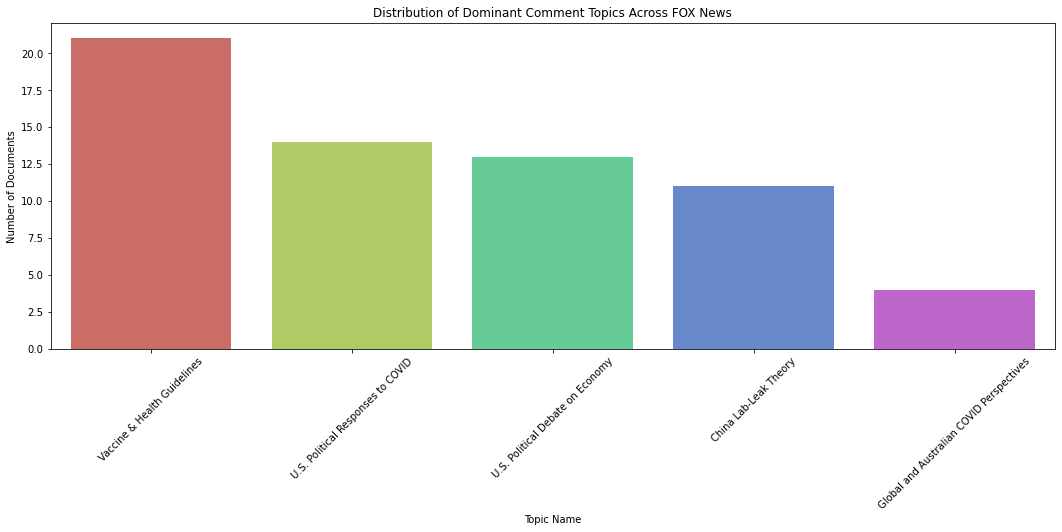

In [30]:
dominant_topics_df = format_topics_documents(ldamodel=lda_model, corpus=corpus)
topic_counts = dominant_topics_df['Dominant_Topic'].value_counts().reset_index(name="Num_Documents")
topic_counts.columns = ['Topic_Num', 'Num_Documents']
topic_counts = topic_counts.merge(dominant_topics_df[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().rename(columns={'Dominant_Topic':'Topic_Num'}), on='Topic_Num', how='left')

topic_names = {
    0: 'Vaccine & Health Guidelines',
    1: 'U.S. Political Responses to COVID',
    2: 'China Lab-Leak Theory',
    3: 'Global and Australian COVID Perspectives',
    4: 'U.S. Political Debate on Economy'
}

topic_counts['Topic'] = topic_counts['Topic_Num'].map(topic_names)

plt.figure(figsize=(18, 6))

sns.barplot(x='Topic', y='Num_Documents', data=topic_counts, palette='hls')
plt.xlabel('Topic Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.title('Distribution of Dominant Comment Topics Across FOX News')
plt.show()

In [31]:
comments_by_video = msnbc_df.groupby('Video Title')['reduced_comment'].agg(comment2document).reset_index()
dictionary = gensim.corpora.Dictionary(comments_by_video['reduced_comment'])
corpus = [dictionary.doc2bow(text) for text in comments_by_video['reduced_comment']]

lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=5,
                random_state=42,
                update_every=1,
                chunksize=100,
                passes=15,
                alpha='auto')

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.035*"people" + 0.018*"vaccine" + 0.017*"covid" + 0.012*"like" + 0.012*"news" + 0.012*"vaccinated" + 0.009*"trump" + 0.008*"fox" + 0.008*"know" + 0.007*"right"

Topic: 1
Words: 0.044*"rachel" + 0.039*"susan" + 0.034*"love" + 0.021*"thank" + 0.019*"beautiful" + 0.015*"people" + 0.013*"hope" + 0.012*"look" + 0.012*"best" + 0.011*"stay"

Topic: 2
Words: 0.028*"gates" + 0.024*"people" + 0.015*"pandemic" + 0.014*"know" + 0.014*"like" + 0.013*"world" + 0.012*"virus" + 0.011*"man" + 0.010*"god" + 0.010*"vaccine"

Topic: 3
Words: 0.045*"trump" + 0.022*"people" + 0.013*"like" + 0.013*"virus" + 0.012*"president" + 0.009*"america" + 0.008*"world" + 0.008*"country" + 0.007*"covid" + 0.007*"news"

Topic: 4
Words: 0.037*"vaccine" + 0.023*"people" + 0.015*"like" + 0.014*"virus" + 0.012*"know" + 0.009*"vaccines" + 0.009*"god" + 0.009*"children" + 0.008*"thank" + 0.008*"kids"



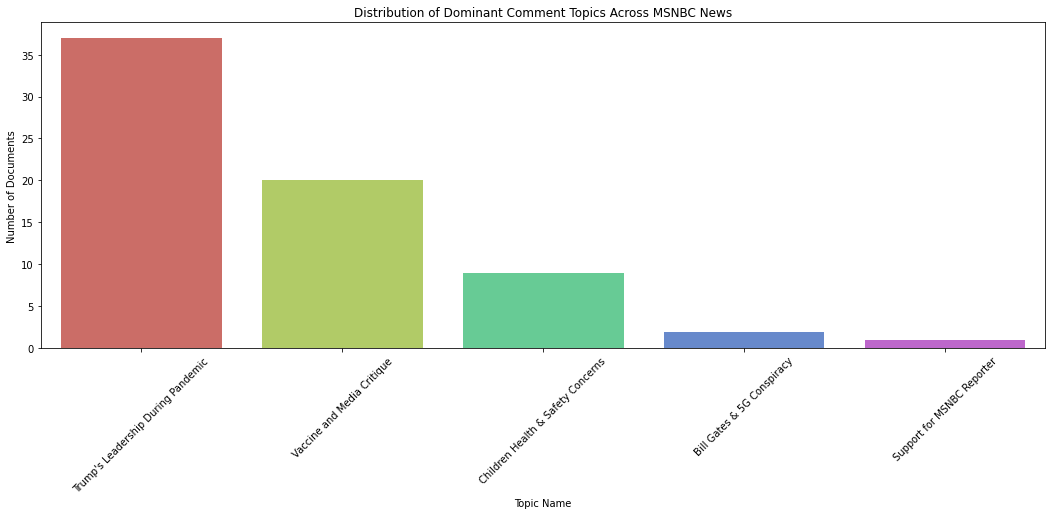

In [33]:
dominant_topics_df = format_topics_documents(ldamodel=lda_model, corpus=corpus)
topic_counts = dominant_topics_df['Dominant_Topic'].value_counts().reset_index(name="Num_Documents")
topic_counts.columns = ['Topic_Num', 'Num_Documents']
topic_counts = topic_counts.merge(dominant_topics_df[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().rename(columns={'Dominant_Topic':'Topic_Num'}), on='Topic_Num', how='left')

topic_names = {
    0: 'Vaccine and Media Critique',
    1: 'Support for MSNBC Reporter',
    2: 'Bill Gates & 5G Conspiracy',
    3: "Trump's Leadership During Pandemic",
    4: 'Children Health & Safety Concerns'
}

topic_counts['Topic'] = topic_counts['Topic_Num'].map(topic_names)

plt.figure(figsize=(18, 6))

sns.barplot(x='Topic', y='Num_Documents', data=topic_counts, palette='hls')
plt.xlabel('Topic Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.title('Distribution of Dominant Comment Topics Across MSNBC News')
plt.show()

## 2.2 Chinese-Keywords-Filtered Comments

In [35]:
comments_by_video = china_df.groupby('Video Title')['reduced_comment'].agg(comment2document).reset_index()
dictionary = gensim.corpora.Dictionary(comments_by_video['reduced_comment'])
corpus = [dictionary.doc2bow(text) for text in comments_by_video['reduced_comment']]

lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=5,
                random_state=24,
                update_every=1,
                chunksize=100,
                passes=15,
                alpha='auto')

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.070*"china" + 0.038*"virus" + 0.031*"wuhan" + 0.027*"chinese" + 0.023*"lab" + 0.019*"ccp" + 0.017*"world" + 0.014*"people" + 0.011*"fauci" + 0.009*"came"

Topic: 1
Words: 0.042*"vaccine" + 0.034*"covid" + 0.022*"vaccines" + 0.021*"people" + 0.017*"sars" + 0.015*"fauci" + 0.012*"communist" + 0.011*"vaccinated" + 0.010*"virus" + 0.008*"flu"

Topic: 2
Words: 0.080*"china" + 0.051*"world" + 0.042*"money" + 0.041*"virus" + 0.036*"vaccine" + 0.028*"americans" + 0.022*"joe" + 0.019*"ccp" + 0.018*"open" + 0.018*"run"

Topic: 3
Words: 0.065*"china" + 0.023*"trump" + 0.022*"people" + 0.021*"virus" + 0.013*"chinese" + 0.012*"like" + 0.011*"communist" + 0.010*"world" + 0.009*"biden" + 0.009*"country"

Topic: 4
Words: 0.035*"quot" + 0.031*"video" + 0.025*"dr" + 0.024*"new" + 0.022*"words" + 0.019*"sheep" + 0.017*"amp" + 0.016*"big" + 0.014*"research" + 0.013*"word"



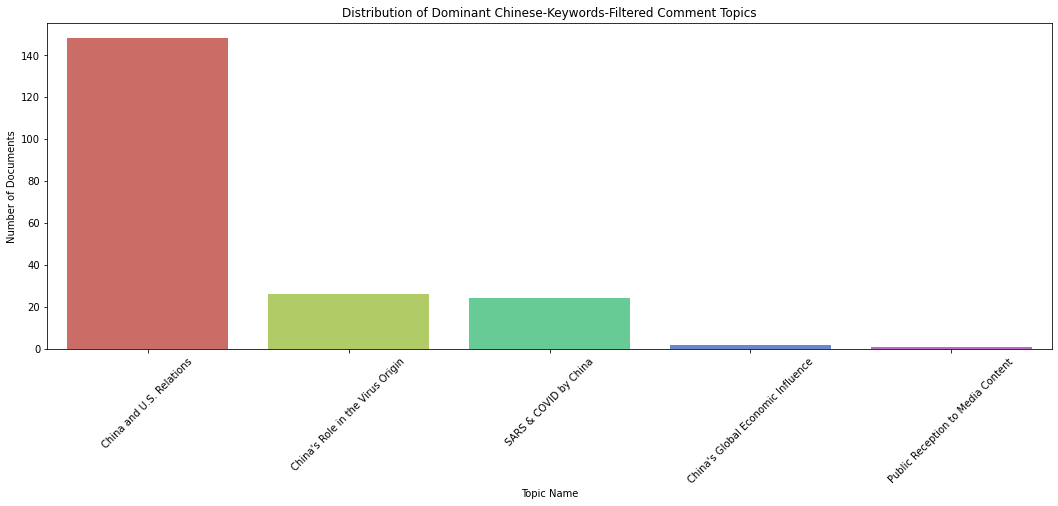

In [37]:
dominant_topics_df = format_topics_documents(ldamodel=lda_model, corpus=corpus)
topic_counts = dominant_topics_df['Dominant_Topic'].value_counts().reset_index(name="Num_Documents")
topic_counts.columns = ['Topic_Num', 'Num_Documents']
topic_counts = topic_counts.merge(dominant_topics_df[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().rename(columns={'Dominant_Topic':'Topic_Num'}), on='Topic_Num', how='left')

topic_names = {
    0: "China's Role in the Virus Origin",
    1: 'SARS & COVID by China',
    2: "China's Global Economic Influence",
    3: "China and U.S. Relations",
    4: 'Public Reception to Media Content'
}

topic_counts['Topic'] = topic_counts['Topic_Num'].map(topic_names)

plt.figure(figsize=(18, 6))

sns.barplot(x='Topic', y='Num_Documents', data=topic_counts, palette='hls')
plt.xlabel('Topic Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.title('Distribution of Dominant Chinese-Keywords-Filtered Comment Topics')
plt.show()

## 2.3 Sinophobic Comments

In [38]:
sinophobia_df = china_df[china_df['Hate Speech Score'] > 0.34]

In [40]:
comments_by_video = sinophobia_df.groupby('Video Title')['reduced_comment'].agg(comment2document).reset_index()
dictionary = gensim.corpora.Dictionary(comments_by_video['reduced_comment'])
corpus = [dictionary.doc2bow(text) for text in comments_by_video['reduced_comment']]

lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,
                num_topics=5,
                random_state=24,
                update_every=1,
                chunksize=100,
                passes=15,
                alpha='auto')

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.085*"china" + 0.034*"virus" + 0.031*"chinese" + 0.026*"world" + 0.015*"people" + 0.015*"trump" + 0.014*"ccp" + 0.010*"communist" + 0.010*"government" + 0.009*"like"

Topic: 1
Words: 0.019*"vaccine" + 0.019*"quot" + 0.017*"new" + 0.015*"video" + 0.014*"gates" + 0.013*"god" + 0.013*"dr" + 0.013*"big" + 0.012*"words" + 0.011*"beast"

Topic: 2
Words: 0.096*"china" + 0.033*"chinese" + 0.031*"people" + 0.025*"virus" + 0.018*"world" + 0.015*"like" + 0.011*"wuhan" + 0.010*"stop" + 0.008*"need" + 0.008*"eat"

Topic: 3
Words: 0.062*"china" + 0.055*"wuhan" + 0.054*"lab" + 0.033*"virus" + 0.030*"fauci" + 0.021*"came" + 0.018*"gain" + 0.018*"bat" + 0.015*"sars" + 0.015*"chinese"

Topic: 4
Words: 0.061*"china" + 0.021*"communist" + 0.020*"people" + 0.018*"biden" + 0.017*"trump" + 0.015*"america" + 0.014*"virus" + 0.014*"like" + 0.012*"covid" + 0.011*"president"



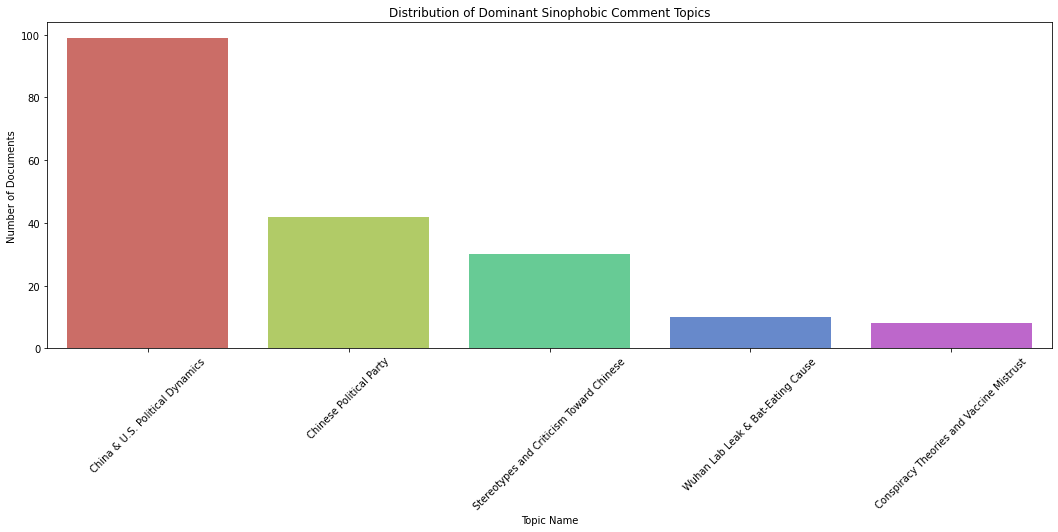

In [41]:
dominant_topics_df = format_topics_documents(ldamodel=lda_model, corpus=corpus)
topic_counts = dominant_topics_df['Dominant_Topic'].value_counts().reset_index(name="Num_Documents")
topic_counts.columns = ['Topic_Num', 'Num_Documents']
topic_counts = topic_counts.merge(dominant_topics_df[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().rename(columns={'Dominant_Topic':'Topic_Num'}), on='Topic_Num', how='left')

topic_names = {
    0: "Chinese Political Party",
    1: 'Conspiracy Theories and Vaccine Mistrust',
    2: "Stereotypes and Criticism Toward Chinese",
    3: "Wuhan Lab Leak & Bat-Eating Cause",
    4: 'China & U.S. Political Dynamics'
}

topic_counts['Topic'] = topic_counts['Topic_Num'].map(topic_names)

plt.figure(figsize=(18, 6))

sns.barplot(x='Topic', y='Num_Documents', data=topic_counts, palette='hls')
plt.xlabel('Topic Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.title('Distribution of Dominant Sinophobic Comment Topics')
plt.show()

# 3. Sentiment Analysis on Chinese Related Comments

In [113]:
client = OpenAI(
    api_key=openai.api_key,
)

In [114]:
def classify_sentiment(comment):
    '''Function to classify sentiment using OpenAI API'''

    messages = [
        {"role": "system", "content": "You are an AI trained to analyze\
         sentiment. Categorize the given comment into one of the\
         emotions: Anger, Fear, Sadness, Irony/Sarcasm, Neutral, Joy."},
        {"role": "user", "content": comment}
    ]
    
    response = client.chat.completions.create(model="gpt-3.5-turbo", messages=messages)
    sentiment = response.choices[0].message.content

    return sentiment

In [86]:
llm_sample = china_df[['Comment']].sample(n=3, random_state=42)
print(llm_sample.iloc[0]['Comment'])
print(llm_sample.iloc[1]['Comment'])
print(llm_sample.iloc[2]['Comment'])

All epidemiologists around the world saw this coming because, as Dr. Corbett said, the 2 previous coronavirus outbreaks (SARS &amp; MERS) were nasty and there were a lot of reasons to expect another.*  Also, scientists were studying the medical use of mRNA long before any of these highly contagious serious coronaviruses came along.  The technology to work with mRNA was available, the knowledge about coronaviruses, especially the fact that they have a “crown”, the spikes, was already available, and knowledge of how to make a vaccine was available.  When the the SARS-CoV-2 sequence arrived, these NIH scientists were ready to map it, find the specific part of the entire genome that created the spike and learn to rapidly grow only that part.  The disease causing parts of the genetic code aren’t in these vaccines.  The vaccine teaches the body to recognize the spikes, which attach to our cells and are the metaphorical doorway for the disease causing code to get in.  The spikes themselves do

In [115]:
llm_sample['LLM Sentiment'] = llm_sample['Comment'].apply(classify_sentiment)
llm_sample

,Comment,LLM Sentiment
23165,All epidemiologists around the world saw this ...,Joy
15204,Also there is an accepted practice when new ne...,Anger
23340,Dr Fauci said the pandemic isn&#39;t over yet....,Anger


In [95]:
china_df_split = np.array_split(china_df, 5)
print(len(china_df_split[0]))
print(len(china_df_split[1]))
print(len(china_df_split[2]))
print(len(china_df_split[3]))
print(len(china_df_split[4]))

china0 = china_df_split[0]
china1 = china_df_split[1]
china2 = china_df_split[2]
china3 = china_df_split[3]
china4 = china_df_split[4]

4752
4752
4752
4751
4751


In [97]:
tqdm.pandas(desc="Classifying comments using LLM")
china0['LLM Sentiment'] = china0['Comment'].progress_apply(classify_sentiment)

Classifying comments using LLM:   0%|          | 0/4752 [00:00<?, ?it/s]

In [101]:
tqdm.pandas(desc="Classifying comments using LLM")
china1['LLM Sentiment'] = china1['Comment'].progress_apply(classify_sentiment)

Classifying comments using LLM:   0%|          | 0/4752 [00:00<?, ?it/s]

In [104]:
tqdm.pandas(desc="Classifying comments using LLM")
china2['LLM Sentiment'] = china2['Comment'].progress_apply(classify_sentiment)

Classifying comments using LLM:   0%|          | 0/4752 [00:00<?, ?it/s]

In [110]:
client = OpenAI(
    api_key=openai.api_key,
)

In [118]:
tqdm.pandas(desc="Classifying comments using LLM")
china3['LLM Sentiment'] = china3['Comment'].progress_apply(classify_sentiment)

Classifying comments using LLM:   0%|          | 0/4751 [00:00<?, ?it/s]

In [116]:
tqdm.pandas(desc="Classifying comments using LLM")
china4['LLM Sentiment'] = china4['Comment'].progress_apply(classify_sentiment)

Classifying comments using LLM:   0%|          | 0/4751 [00:00<?, ?it/s]

In [153]:
china_sentiment = pd.concat([china0, china1, china2, china3, china4], axis=0)

In [154]:
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].apply(
    lambda x: "Anger" if re.search(r'\banger\b', x, flags=re.IGNORECASE) else x
)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].apply(
    lambda x: "Fear" if re.search(r'\bfear\b', x, flags=re.IGNORECASE) else x
)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].apply(
    lambda x: "Sadness" if re.search(r'\bsadness\b', x, flags=re.IGNORECASE) else x
)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].apply(
    lambda x: "Irony/Sarcasm" if re.search(r'\birony/sarcasm\b', x, flags=re.IGNORECASE) else x
)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].apply(
    lambda x: "Neutral" if re.search(r'\bneutral\b', x, flags=re.IGNORECASE) else x
)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].apply(
    lambda x: "Joy" if re.search(r'\bjoy\b', x, flags=re.IGNORECASE) else x
)

In [160]:
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Confusion', 'Neutral', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Confusion.', 'Neutral', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Disgust', 'Anger', regex=True)

china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Criticism / Irony', 'Irony/Sarcasm', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Ironic/Sarcasm', 'Irony/Sarcasm', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Sarcasm/Irony', 'Irony/Sarcasm', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Fears', 'Fear', regex=True)

china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Neutral.', 'Neutral', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Conspiracy Theory', 'Neutral', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('Uncertain/Skepticism', 'Neutral', regex=True)
china_sentiment['LLM Sentiment'] = china_sentiment['LLM Sentiment'].replace('The sentiment in the given comment is confusion.', 'Neutral', regex=True)

In [170]:
china_sentiment.loc[13687]['Comment']

'She mentions the CCP has a friend in the scientific world that helped create this... Why didnt she say who that friend was?'

In [171]:
china_sentiment.loc[2856, 'LLM Sentiment'] = 'Anger'
china_sentiment.loc[4711, 'LLM Sentiment'] = 'Anger'
china_sentiment.loc[5310, 'LLM Sentiment'] = 'Fear'
china_sentiment.loc[6434, 'LLM Sentiment'] = 'Anger'
china_sentiment.loc[13687, 'LLM Sentiment'] = 'Neutral'
china_sentiment.loc[14934, 'LLM Sentiment'] = 'Neutral'

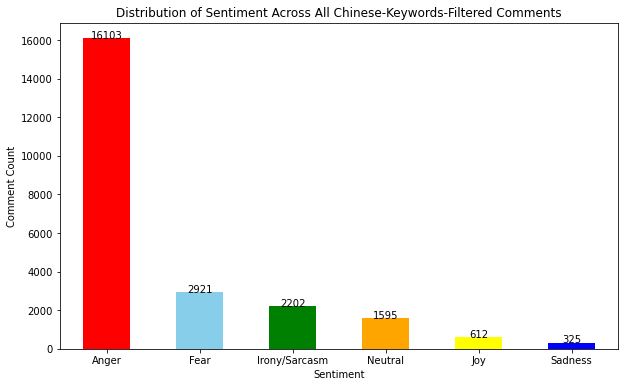

In [237]:
sentiment_counts = china_sentiment['LLM Sentiment'].value_counts()

plt.figure(figsize=(10, 6))
colors = ['red', 'skyblue', 'green', 'orange', 'yellow', 'blue'] 
ax = sentiment_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Sentiment Across All Chinese-Keywords-Filtered Comments')
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.xticks(rotation=0)
for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 0.2, str(v), color='black', ha='center')
plt.show()

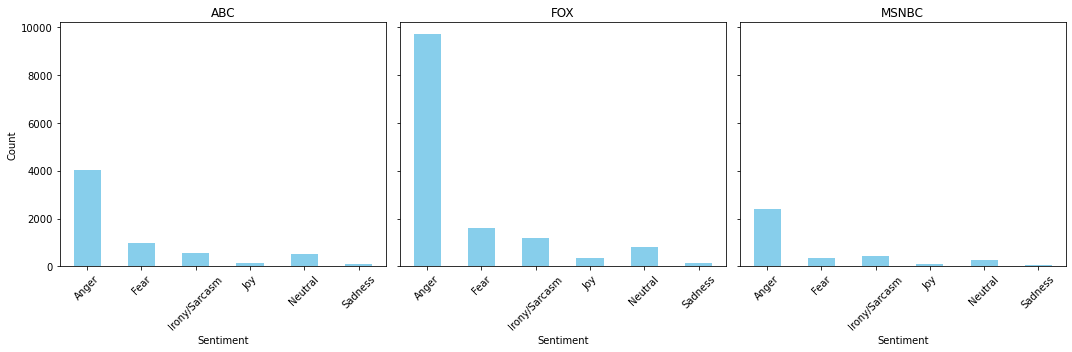

In [187]:
grouped_data = china_sentiment.groupby('Channel')['LLM Sentiment'].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for ax, channel in zip(axes, ['ABC', 'FOX', 'MSNBC']):
    if channel in grouped_data.index:
        grouped_data.loc[channel].plot(kind='bar', ax=ax, title=channel, color='skyblue')
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [212]:
china_sentiment.iloc[4300]['Comment']

'Let&#39;s let trump call it the Wuhan virus that&#39;s ok but let it be forever known as the &quot;trump pandemic &quot; that&#39;s killing America.'

In [211]:
china_sentiment.iloc[2300]['LLM Sentiment']
china_sentiment.iloc[3300]['LLM Sentiment']
china_sentiment.iloc[4300]['LLM Sentiment']

'Irony/Sarcasm'

In [186]:
china_sentiment.to_csv('china_sentiment_df.csv')